In [76]:
import pandas as pd
import numpy as np
import pymysql

'''
    预测单价 * 面积=预测的房价
'''

conn = pymysql.connect(host="10.29.30.25", port=3306, user="root", passwd="!QAZ2wsx", db="ETL", charset="utf8")
df=pd.read_sql("select id,community_id,region_id,community_address,part_area_id,house_type,transaction_price,build_area,"
               "transaction_unit_price,transaction_time,community_unit_price,orientation,decoration_level,current_floor,"
               "total_floor,year_built,type_built from cd_apartmentinfo_convert",con=conn)

df.drop("id",1,inplace=True)
df.drop("community_address",1,inplace=True)
df.drop("transaction_price",1,inplace=True)
df.drop("build_area",1,inplace=True)

import re
def layout_spilt(x):
    if "室" in x:
        a = re.search("(\d+)室(\d+)厅(\d+)厨(\d+)卫", x).group(1)
    else:
        a = 0
    if "厅" in x:
        b = re.search("(\d+)室(\d+)厅(\d+)厨(\d+)卫", x).group(2)
    else:
        b = 0
    if "厨" in x:
        c = re.search("(\d+)室(\d+)厅(\d+)厨(\d+)卫", x).group(3)
    else:
        c = 0
    if "卫" in x:
        d = re.search("(\d+)室(\d+)厅(\d+)厨(\d+)卫", x).group(4)
    else:
        d = 0
    return a, b, c, d

def time_split(x):
    return x.year,x.month

list_df = []
for i, row in df.iterrows():
    a, b, c, d = layout_spilt(row["house_type"])
    e, f=time_split(row["transaction_time"])
    list_df.append([a, b, c, d, e, f])


#特征工程
new_pd=pd.DataFrame(list_df)
new_pd.rename(columns={0:"layout0",1:"layout1",2:"layout2",3:"layout3",4:"time4",5:"time5"},inplace=True)
a=pd.merge(df,new_pd,right_index=True,left_index=True)
orientation_map={"东":1,"西":2,"南":3,"北":4,"东南":5,"西北":6,"西南":7,"东北":8,"南北":9,"东西":10,"暂无":11}
decoration_level_map={"精装":1,"简装":2,"毛坯":3,"其他":4}
current_floor_map={"高楼层":1,"低楼层":2,"中楼层":3,"地下室":4,"未知":5}
a.orientation=a.orientation.map(orientation_map)
a.decoration_level=a.decoration_level.map(decoration_level_map)
a.current_floor=a.current_floor.map(current_floor_map)
price=a.transaction_unit_price
a.drop("house_type",1,inplace=True)
a.drop("transaction_unit_price",1,inplace=True)
a.drop("transaction_time",1,inplace=True)
a.drop("community_unit_price",1,inplace=True)
a.drop("type_built",1,inplace=True)
a.drop("current_floor",1,inplace=True)
a.drop("total_floor",1,inplace=True)
a.drop("year_built",1,inplace=True)
dd=pd.concat([price,a],axis=1)



# print(dd[dd.isnull().values==True])
from sklearn import linear_model

train_np = dd.as_matrix()

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

# 训练集测试集划分
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

[13519.155945   13661.15811638 16053.57415341 ...  8182.09520611
 11244.88456466 11546.97865834]
[17654.0 13738.0 7945.0 ... 10912.0 17662.0 13942.0]
plot


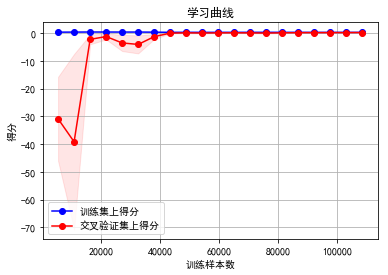

,coef,columns
0,0.086958,community_id
1,-290290.193218,region_id
2,-8666.766193,part_area_id
3,47.023429,orientation
4,-50.043496,decoration_level
5,89.209863,layout0
6,-96.049878,layout1
7,-3502.806024,layout2
8,483.355173,layout3
9,2233.644305,time4


In [89]:

# model one
clf = linear_model.LinearRegression()
clf.fit(x_train, y_train)
prediction=clf.predict(x_test)
print(prediction)
print(y_test)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        print("plot")
        plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
        plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff
# clf
plot_learning_curve(clf, u"学习曲线", X, y)
pd.DataFrame({"columns":list(dd.columns)[1:],"coef":list(clf.coef_.T)})

In [78]:
# model two
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

import matplotlib.pyplot as pl
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split


def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and validation scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)


    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):
        
        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, valid_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        valid_std = np.std(valid_scores, axis = 1)
        valid_mean = np.mean(valid_scores, axis = 1)
#         print train_mean
#         print train_scores

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, valid_mean, 'o-', color = 'g', label = 'Validation Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, valid_mean - valid_std, \
            valid_mean + valid_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('r2_score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()


def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and validation errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot the validation curve
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, valid_mean, 'o-', color = 'g', label = 'Validation Score')
    pl.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, valid_mean - valid_std, \
        valid_mean + valid_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('r2_score')
    pl.ylim([-0.05,1.05])
    pl.show()


def PredictTrials(X, y, fitter, data):
    """ Performs trials of fitting and predicting data. """

    # Store the predicted prices
    prices = []

    for k in range(10):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)
        
        # Fit the data
        reg = fitter(X_train, y_train)
        
        # Make a prediction
        pred = reg.predict([data[0]])[0]
        prices.append(pred)
        
        # Result
        print("Trial {}: ${:,.2f}".format(k+1, pred))

    # Display price range
    print("\nRange in prices: ${:,.2f}".format(max(prices) - min(prices)))

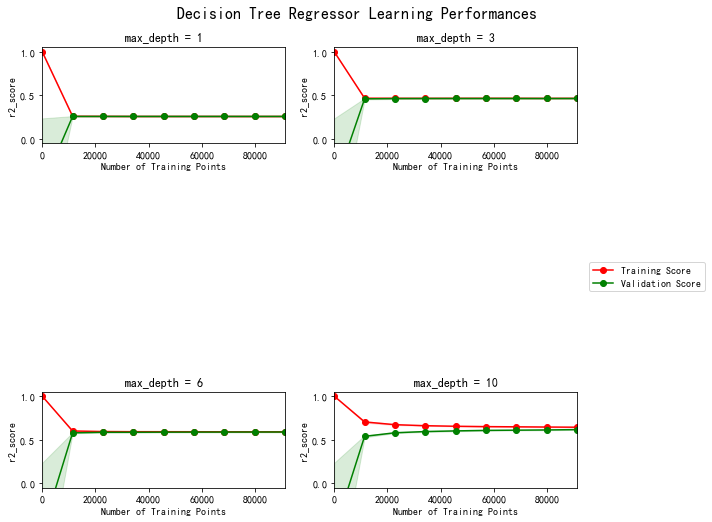

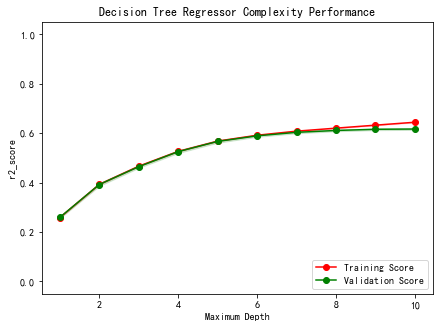

最理想模型的参数 'max_depth' 是 10 。
最优模型在测试数据上 R^2 分数 0.62。


In [81]:

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# 利用GridSearchCV计算最优解
def fit_model(X, y):
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的决策树模型"""
    
    cross_validator = KFold(10, shuffle=True)
      
    regressor = DecisionTreeRegressor()
    
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
    
    scoring_fnc = make_scorer(performance_metric)
    
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cross_validator)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
#     print pd.DataFrame(grid.cv_results_)
    return grid.best_estimator_

# 计算R2分数
def performance_metric(y_true, y_predict):
    """计算并返回预测值相比于预测值的分数"""
    from sklearn.metrics import r2_score
    score = r2_score(y_true, y_predict)

    return score


# import visuals as vs

# # 分析模型
ModelLearning(x_train, y_train)
ModelComplexity(x_train, y_train)

optimal_reg1 = fit_model(x_train, y_train)

# 输出最优模型的 'max_depth' 参数
print("最理想模型的参数 'max_depth' 是 {} 。".format(optimal_reg1.get_params()['max_depth']))

predicted_value = optimal_reg1.predict(x_test)
r2 = performance_metric(y_test, predicted_value)

print("最优模型在测试数据上 R^2 分数 {:,.2f}。".format(r2))